In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pred_sa1_geo = gpd.read_file("Assigned_Pop\pred_sa1_geo.geojson")
print(f"Total pred: {sum(pred_sa1_geo['pred_evs'])}, Total int: {sum(pred_sa1_geo['int_evs'])}")

Total pred: 5872.409891461022, Total int: 5872


In [3]:
synthetic = pd.read_csv("Data\clean_data.csv")
corr_df = pd.read_csv('Data\\feature_selection\\att_rank_pearson.csv')[["key", "pearson_score", "p_value"]].dropna()

In [4]:
pred_ev_sa1 = pred_sa1_geo[["SA1_CODE21", "int_evs"]]
pred_ev_sa1["SA1_CODE21"] = pred_ev_sa1["SA1_CODE21"].astype(str)
synthetic["SA1_CODE21"] = synthetic["SA1_CODE21"].astype(str)
synthetic = synthetic.merge(pred_ev_sa1, on="SA1_CODE21", how="left")
synthetic["house_id"] = synthetic.index
synthetic

C:\Users\danla\AppData\Local\Temp\ipykernel_8636\3571944392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ev_sa1["SA1_CODE21"] = pred_ev_sa1["SA1_CODE21"].astype(str)


,SA1_CODE21,INC,TOTALVEHS,HHSIZE,dwelltype_Flat or Apartment,dwelltype_Other,dwelltype_Separate House,dwelltype_Terrace/Townhouse,owndwell_Being Purchased,owndwell_Being Rented,owndwell_Fully Owned,owndwell_Occupied Rent-Free,owndwell_Something Else,int_evs,house_id
0,20302104732,350.0,1.0,3.0,0,0,1,0,1,0,0,0,0,0.0,0
1,20302104732,3600.0,0.0,2.0,0,0,1,0,0,0,1,0,0,0.0,1
2,20302104732,1900.0,1.0,2.0,0,0,1,0,0,0,1,0,0,0.0,2
3,20302104732,350.0,3.0,3.0,0,0,1,0,0,0,1,0,0,0.0,3
4,20302104732,800.0,2.0,2.0,0,0,1,0,1,0,0,0,0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901069,21402159223,2850.0,1.0,1.0,0,1,0,0,0,0,1,0,0,1.0,1901069
1901070,21402159223,3200.0,2.0,1.0,0,0,1,0,0,0,1,0,0,1.0,1901070
1901071,21402159223,2800.0,1.0,1.0,0,0,1,0,1,0,0,0,0,1.0,1901071
1901072,21402159223,3000.0,0.0,1.0,1,0,0,0,0,1,0,0,0,1.0,1901072


In [5]:
synthetic_bins = synthetic.copy()

inc_bins = [-1, 0, 149, 299, 399, 499, 649, 799, 999, 1249, 1499, 1749, 1999, 2499, 2999, 3499, 3999, 4499, 4999, 5999, 7999, np.inf]
hhsize_bins = [1, 2, 3, 4, 5, 6, 7, np.inf]
vehs_bins = [-1, 0, 1, 2, 3, np.inf]
synthetic_bins["INC_bins"] = pd.cut(synthetic_bins["INC"], bins=inc_bins)
synthetic_bins["HHSIZE_bins"] = pd.cut(synthetic_bins["HHSIZE"], bins=hhsize_bins)
synthetic_bins["TOTALVEHS_bins"] = pd.cut(synthetic_bins["TOTALVEHS"], bins=vehs_bins)

#synthetic_bins = synthetic_bins.drop(columns=["HHSIZE", "TOTALVEHS", "INC", "HHSIZE_normalised", "TOTALVEHS_normalised", "INC_normalised"])
synthetic_bins = synthetic_bins.drop(columns=["HHSIZE", "TOTALVEHS", "INC"])
synthetic_bins = pd.get_dummies(synthetic_bins, columns=['INC_bins'], prefix='INC')
synthetic_bins = pd.get_dummies(synthetic_bins, columns=['HHSIZE_bins'], prefix='HHSIZE')
synthetic_bins = pd.get_dummies(synthetic_bins, columns=['TOTALVEHS_bins'], prefix='TOTALVEHS')

In [6]:
# Your dictionary data
multiplier_df = corr_df

# Sample DataFrame to be multiplied
df = synthetic_bins.drop(columns=["SA1_CODE21"])

# Create a dictionary from the multiplier DataFrame
multiplier_dict = dict(zip(multiplier_df['key'], multiplier_df['pearson_score']))

In [7]:
df_result = df * df.columns.map(multiplier_dict)
df_result["score"] = df_result.drop(columns="house_id").sum(axis=1)
df_result[["SA1_CODE21"]] = synthetic_bins[["SA1_CODE21"]]

df_result["assign_ev"] = 0
move_columns = ["house_id", "score", "assign_ev", "SA1_CODE21"]

df_result = df_result[move_columns + [col for col in df_result.columns if col not in move_columns]]
df_result

,house_id,score,assign_ev,SA1_CODE21,dwelltype_Flat or Apartment,dwelltype_Other,dwelltype_Separate House,dwelltype_Terrace/Townhouse,owndwell_Being Purchased,owndwell_Being Rented,...,"HHSIZE_(3.0, 4.0]","HHSIZE_(4.0, 5.0]","HHSIZE_(5.0, 6.0]","HHSIZE_(6.0, 7.0]","HHSIZE_(7.0, inf]","TOTALVEHS_(-1.0, 0.0]","TOTALVEHS_(0.0, 1.0]","TOTALVEHS_(1.0, 2.0]","TOTALVEHS_(2.0, 3.0]","TOTALVEHS_(3.0, inf]"
0,0.0,0.155160,0,20302104732,0.000000,-0.000000,-0.085829,0.0,0.119079,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.043533,0.00000,-0.000000,-0.0
1,1.0,-0.101160,0,20302104732,0.000000,-0.000000,-0.085829,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.058811,0.000000,0.00000,-0.000000,-0.0
2,2.0,-0.239749,0,20302104732,0.000000,-0.000000,-0.085829,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.043533,0.00000,-0.000000,-0.0
3,3.0,-0.152698,0,20302104732,0.000000,-0.000000,-0.085829,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,-0.031328,-0.0
4,4.0,-0.087372,0,20302104732,0.000000,-0.000000,-0.085829,0.0,0.119079,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.09801,-0.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901069,1901069.0,0.021787,0,21402159223,0.000000,-0.018405,-0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.043533,0.00000,-0.000000,-0.0
1901070,1901070.0,0.055612,0,21402159223,0.000000,-0.000000,-0.085829,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.09801,-0.000000,-0.0
1901071,1901071.0,0.187360,0,21402159223,0.000000,-0.000000,-0.085829,0.0,0.119079,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.043533,0.00000,-0.000000,-0.0
1901072,1901072.0,0.363705,0,21402159223,0.077724,-0.000000,-0.000000,0.0,0.000000,0.069819,...,0.0,0.0,0.0,0.0,0.0,0.058811,0.000000,0.00000,-0.000000,-0.0


## Run to generate ev_pop

In [8]:
def assign_ev_by_sa1(df, sa1_code, x):
    mask = (df['SA1_CODE21'] == sa1_code) & ~(df['TOTALVEHS_(-1.0, 0.0]'] !=0)
    rows_to_assign = np.where(mask)[0][:x]
    df.loc[rows_to_assign, 'assign_ev'] = 1


# Create a dictionary to store the required x values for each SA1_CODE21
x_values_dict = dict(zip(pred_ev_sa1['SA1_CODE21'], pred_ev_sa1['int_evs']))

# Loop through unique SA1_CODE21 values and update 'assign_ev' in a vectorized way
i = 0
df_result.reset_index(drop=True, inplace=True)

for sa1_code in df_result['SA1_CODE21'].unique():
    if i %100 == 0:
       print(i)
        
    i += 1
    x_value = x_values_dict.get(sa1_code, 0)
    
    if x_value > 0:
        assign_ev_by_sa1(df_result, sa1_code, x_value)

# Reset the index of df_result if needed
df_result.reset_index(drop=True, inplace=True)
df_result.to_csv("Assigned_Pop\ev_assign_pop.csv", index=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


In [9]:
df_result[["house_id", "score", "assign_ev"]]

,house_id,score,assign_ev
0,0.0,0.155160,0
1,1.0,-0.101160,0
2,2.0,-0.239749,0
3,3.0,-0.152698,0
4,4.0,-0.087372,0
...,...,...,...
1901069,1901069.0,0.021787,0
1901070,1901070.0,0.055612,0
1901071,1901071.0,0.187360,0
1901072,1901072.0,0.363705,0


In [10]:
assigned_pop = synthetic.drop(columns="int_evs").copy()
assigned_pop = assigned_pop.merge(df_result[["house_id", "score", "assign_ev"]], on='house_id', how="left")
assigned_pop.to_csv("Assigned_Pop\\assigned_pop.csv", index=False)

In [11]:

assigned_pop = pd.read_csv("Assigned_Pop\\assigned_pop.csv")
assigned_pop.sort_values(by="house_id")[["house_id", "score", "assign_ev"]]["assign_ev"].sum()

5870

# Plotting 

In [3]:
sa1 = gpd.read_file("Shape\sa1_to_poa.gpkg")
ev_pop = pd.read_csv("Assigned_Pop\ev_assign_pop.csv")

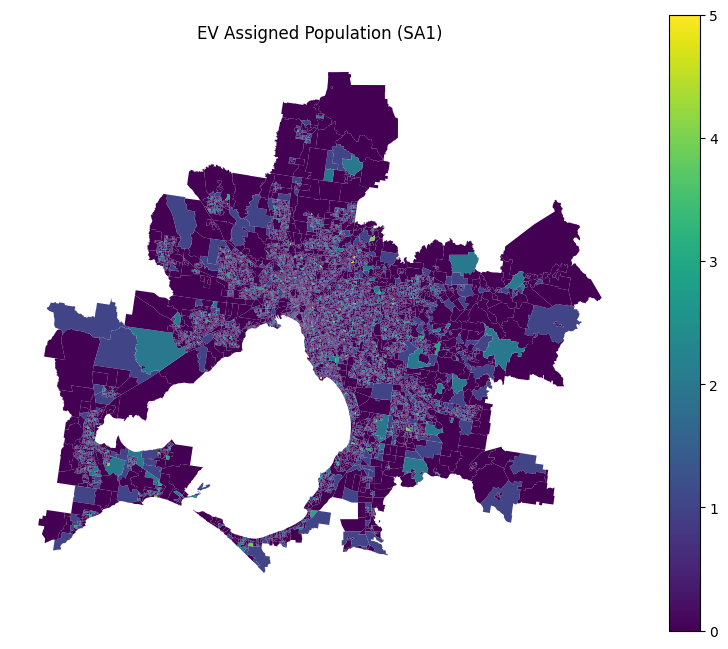

In [5]:
sa1["SA1_CODE21"] = sa1["SA1_CODE21"].astype(str)
ev_pop["SA1_CODE21"] = ev_pop["SA1_CODE21"].astype(str)
merged = sa1.merge(ev_pop.groupby("SA1_CODE21").sum("assign_ev"), on="SA1_CODE21", how="left")
merged["assign_ev"].fillna(0, inplace=True)
merged.to_file("Predictions\\assigned_int_ev_pred.geojson", driver='GeoJSON')
#Create a larger figure

fig, ax1 = plt.subplots(figsize=(10, 8))
merged.plot(column="assign_ev", cmap='viridis', legend=True, ax=ax1)
plt.title("EV Assigned Population (SA1)")
plt.axis('off')
plt.show()

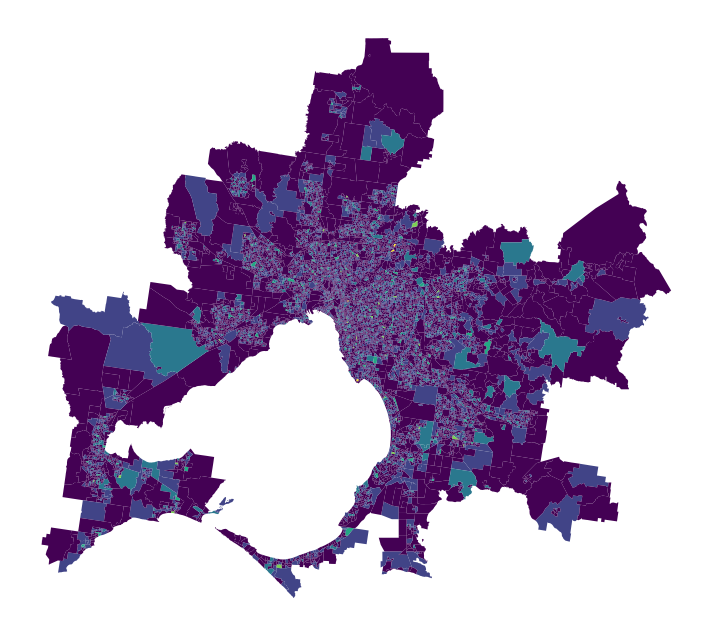

(144.1000697892242, 145.963101027914, -38.51151943757178, -37.20337891044948)

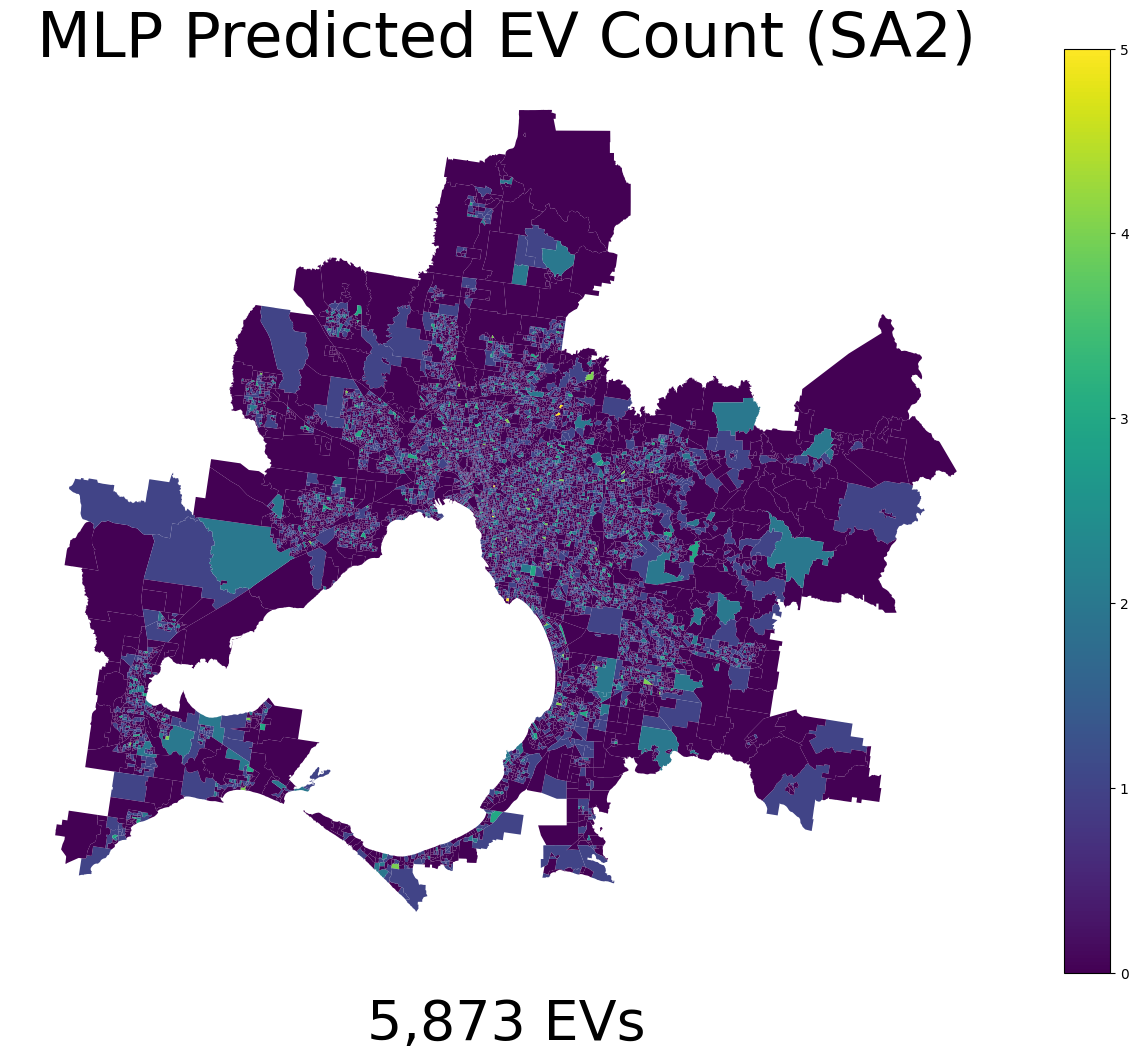

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 8))
merged.plot(column="assign_ev", cmap='viridis', ax=ax1)
plt.axis('off')
plt.show()

my_cmap = "viridis"
plot_x = 16
plot_y = 12
subtitle_fontsize = 40
title_fontsize = 45
legend_fontsize = 20

# Plot 1
fig, ax1 = plt.subplots(figsize=(plot_x, plot_y))
merged.plot(column="assign_ev", cmap=my_cmap, ax=ax1, legend=True)
ax1.set_xticks([])  
ax1.set_yticks([])  
ax1.set_title("MLP Predicted EV Count (SA2)", fontsize=title_fontsize)  
total_ev = int(merged['assign_ev'].sum())
formatted_total_ev = '{:,}'.format(total_ev)
ax1.text(0.5, -0.1, f"{formatted_total_ev} EVs", fontsize=subtitle_fontsize, transform=ax1.transAxes, ha='center') 
ax1.axis('off')